In [8]:
import cv2
import numpy as np
from PIL import Image
import keras
from keras.models import Sequential
from keras.layers import Conv2D, AveragePooling2D, Flatten, Dense

In [13]:
def load_and_preprocess_data(file_path):
    labels = []
    features = []
    
    with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
        for line in file:
            image_file_name, label = line.strip().split(' ')
            image = Image.open(image_file_name)
            image_data = np.array(image)
            
            labels.append(label)
            
            image_data = cv2.cvtColor(image_data, cv2.COLOR_RGB2BGR)
            resized_image = cv2.resize(image_data, (32, 32))
            features.append(resized_image)
    
    features = np.array(features)
    labels = np.array(labels)
    
    features = features.astype("float32") / 255.0
    gray_data = np.mean(features, axis=3, keepdims=True)
    
    # Assuming you have 50 classes
    num_classes = 50
    
    encoded_labels = keras.utils.to_categorical(labels, num_classes)
    
    return gray_data, encoded_labels

train_data, train_labels = load_and_preprocess_data('train.txt')
val_data, val_labels = load_and_preprocess_data('val.txt')
test_data, test_labels = load_and_preprocess_data('test.txt')


In [14]:
print(train_data.shape)
print(train_labels.shape)
print(val_data.shape)
print(val_labels.shape)
print(test_data.shape)
print(test_labels.shape)

(63325, 32, 32, 1)
(63325, 50)
(450, 32, 32, 1)
(450, 50)
(450, 32, 32, 1)
(450, 50)


In [15]:
num_classes = 50
model = Sequential()

model.add(Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=(32, 32, 1)))
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Conv2D(16, kernel_size=(5, 5), activation='relu'))
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(120, activation='relu'))
model.add(Dense(84, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d_4 (Averag  (None, 14, 14, 6)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_5 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_5 (Averag  (None, 5, 5, 16)         0         
 ePooling2D)                                                     
                                                                 
 flatten_2 (Flatten)         (None, 400)               0         
                                                                 
 dense_6 (Dense)             (None, 120)              

In [16]:
import tensorflow as tf

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
batch_size = 32
epochs = 10
history = model.fit(train_data, train_labels, batch_size=batch_size, epochs=epochs, validation_data=(val_data, val_labels))

# Calculate inference time
input_shape = (1, 32, 32, 1)
dummy_input = tf.random.normal(input_shape)
model_path = 'model.h5'
model.save(model_path)
loaded_model = keras.models.load_model(model_path)
input_data = tf.Variable(dummy_input)
f = tf.function(loaded_model).get_concrete_function(input_data)
f2 = convert_variables_to_constants_v2(f)
graph_def = f2.graph.as_graph_def()
run_meta = tf.compat.v1.RunMetadata()
opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
flops = tf.compat.v1.profiler.profile(graph_def=graph_def, run_meta=run_meta, cmd='op', options=opts)
print("FLOPs: ", flops.total_float_ops)

# Calculate space complexity
params = model.count_params()
print("Number of parameters: ", params)

# Save the model's architecture as a PNG image
plot_model(model, to_file='model.png', show_shapes=True)

Epoch 1/10
1979/1979 [==============================] - 10s 5ms/step - loss: 3.6197 - accuracy: 0.0729 - val_loss: 3.4514 - val_accuracy: 0.0956
Epoch 2/10
1979/1979 [==============================] - 9s 5ms/step - loss: 3.3992 - accuracy: 0.1144 - val_loss: 3.3715 - val_accuracy: 0.0889
Epoch 3/10
1979/1979 [==============================] - 10s 5ms/step - loss: 3.2994 - accuracy: 0.1306 - val_loss: 3.3026 - val_accuracy: 0.1244
Epoch 4/10
1979/1979 [==============================] - 9s 5ms/step - loss: 3.2340 - accuracy: 0.1434 - val_loss: 3.3258 - val_accuracy: 0.1178
Epoch 5/10
1979/1979 [==============================] - 10s 5ms/step - loss: 3.1832 - accuracy: 0.1543 - val_loss: 3.2310 - val_accuracy: 0.1378
Epoch 6/10
1979/1979 [==============================] - 10s 5ms/step - loss: 3.1359 - accuracy: 0.1642 - val_loss: 3.1795 - val_accuracy: 0.1578
Epoch 7/10
1979/1979 [==============================] - 9s 5ms/step - loss: 3.0920 - accuracy: 0.1749 - val_loss: 3.2233 - val_accur

UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 26-27: invalid continuation byte

In [32]:
test_loss, test_accuracy = model.evaluate(test_data, test_labels)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


15/15 [==============================] - 0s 2ms/step - loss: 3.1456 - accuracy: 0.1689
Test Loss: 3.145604133605957
Test Accuracy: 0.1688888818025589


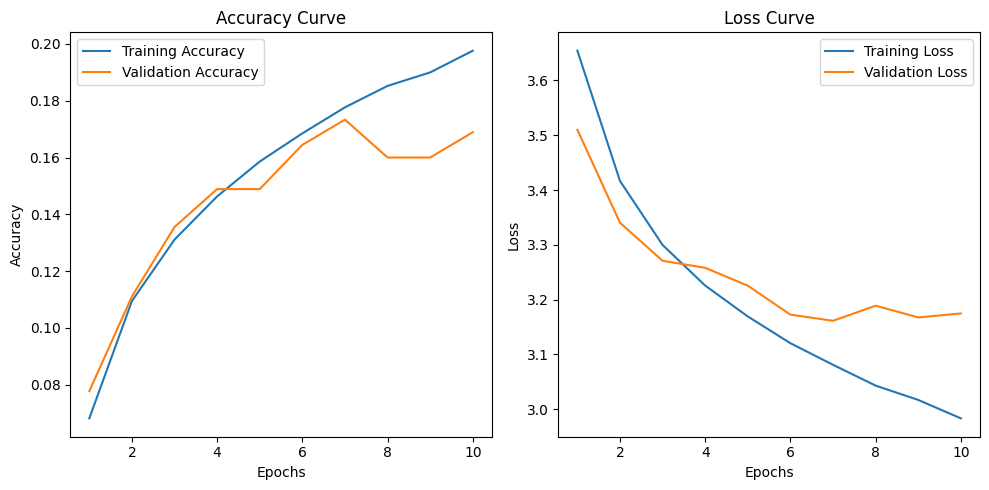

In [33]:
import matplotlib.pyplot as plt



# Extract accuracy and loss values from history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot accuracy curve
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_acc, label='Training Accuracy')
plt.plot(range(1, epochs + 1), val_acc, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss curve
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_loss, label='Training Loss')
plt.plot(range(1, epochs + 1), val_loss, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10

# Define LeNet-5 model
class LeNet5(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet5, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120),
            nn.ReLU(inplace=True),
            nn.Linear(120, 84),
            nn.ReLU(inplace=True),
            nn.Linear(84, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Set random seed for reproducibility
torch.manual_seed(42)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)

val_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

# Initialize LeNet-5 model
model = LeNet5().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    # Training phase
    model.train()
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_predictions / total_predictions

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct_predictions = 0
    val_total_predictions = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            val_total_predictions += labels.size(0)
            val_correct_predictions += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = val_correct_predictions / val_total_predictions

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

# Test phase
model.eval()

test_loss = 0.0
test_correct_predictions = 0
test_total_predictions = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        test_total_predictions += labels.size(0)
        test_correct_predictions += (predicted == labels).sum().item()

test_loss /= len(test_loader)
test_accuracy = test_correct_predictions / test_total_predictions

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Files already downloaded and verified
Files already downloaded and verified
Epoch [1/10], Train Loss: 1.5776, Train Accuracy: 0.4227, Val Loss: 1.3606, Val Accuracy: 0.5014
Epoch [2/10], Train Loss: 1.2888, Train Accuracy: 0.5344, Val Loss: 1.2252, Val Accuracy: 0.5653
Epoch [3/10], Train Loss: 1.1695, Train Accuracy: 0.5828, Val Loss: 1.1464, Val Accuracy: 0.5929
Epoch [4/10], Train Loss: 1.0855, Train Accuracy: 0.6137, Val Loss: 1.1217, Val Accuracy: 0.6048
Epoch [5/10], Train Loss: 1.0264, Train Accuracy: 0.6347, Val Loss: 1.0786, Val Accuracy: 0.6217
Epoch [6/10], Train Loss: 0.9697, Train Accuracy: 0.6558, Val Loss: 1.0895, Val Accuracy: 0.6194
Epoch [7/10], Train Loss: 0.9270, Train Accuracy: 0.6718, Val Loss: 1.0782, Val Accuracy: 0.6278
Epoch [8/10], Train Loss: 0.8857, Train Accuracy: 0.6861, Val Loss: 1.0512, Val Accuracy: 0.6370
Epoch [9/10], Train Loss: 0.8520, Train Accuracy: 0.6980, Val Loss: 1.0658, Val Accuracy: 0.6316
Epoch [10/10], Train Loss: 0.8201, Train Accuracy: 

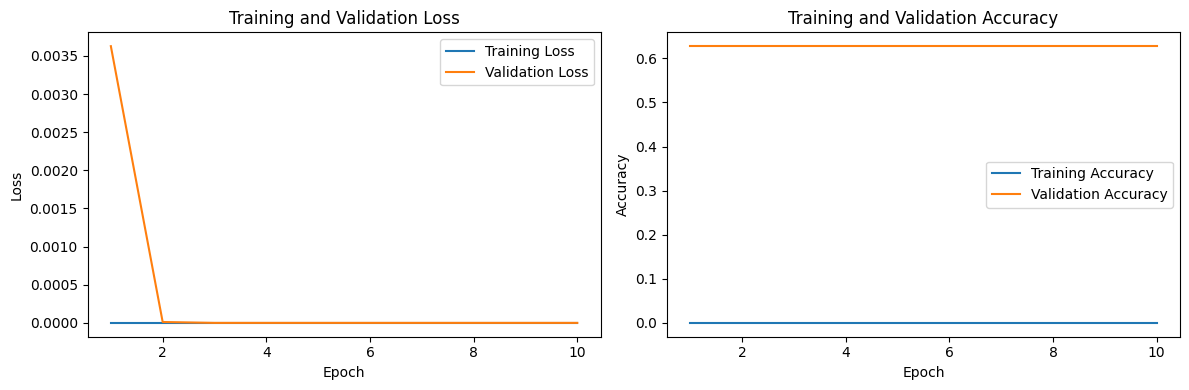

In [35]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    # Training phase
    # ...

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_predictions / (total_predictions + 1e-7)  # Add a small epsilon value

    # Validation phase
    # ...

    val_loss = val_loss / len(val_loader)
    val_accuracy = val_correct_predictions / (val_total_predictions + 1e-7)  # Add a small epsilon value

    # Append accuracy and loss values to lists
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Print epoch results
    # ...

# Test phase
# ...

test_loss = 0.0
test_correct_predictions = 0
test_total_predictions = 0

# Plotting the curves
plt.figure(figsize=(12, 4))

# Plot training and validation loss curves
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

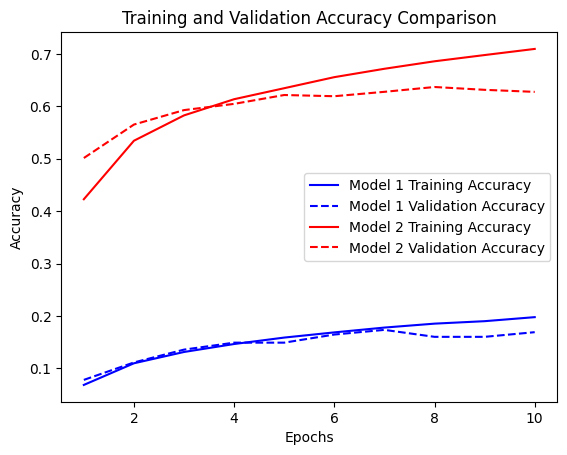

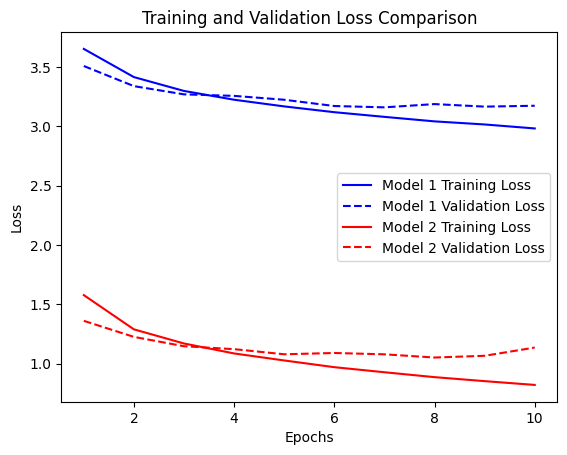

In [37]:
import matplotlib.pyplot as plt

# Model 1 results
model1_train_loss = [3.6542, 3.4165, 3.2997, 3.2256, 3.1693, 3.1205, 3.0811, 3.0431, 3.0170, 2.9834]
model1_val_loss = [3.5098, 3.3403, 3.2709, 3.2581, 3.2254, 3.1726, 3.1614, 3.1889, 3.1675, 3.1748]
model1_train_acc = [0.0682, 0.1095, 0.1311, 0.1463, 0.1586, 0.1685, 0.1777, 0.1852, 0.1899, 0.1976]
model1_val_acc = [0.0778, 0.1111, 0.1356, 0.1489, 0.1489, 0.1644, 0.1733, 0.1600, 0.1600, 0.1689]

# Model 2 results
model2_train_loss = [1.5776, 1.2888, 1.1695, 1.0855, 1.0264, 0.9697, 0.9270, 0.8857, 0.8520, 0.8201]
model2_val_loss = [1.3606, 1.2252, 1.1464, 1.1217, 1.0786, 1.0895, 1.0782, 1.0512, 1.0658, 1.1353]
model2_train_acc = [0.4227, 0.5344, 0.5828, 0.6137, 0.6347, 0.6558, 0.6718, 0.6861, 0.6980, 0.7097]
model2_val_acc = [0.5014, 0.5653, 0.5929, 0.6048, 0.6217, 0.6194, 0.6278, 0.6370, 0.6316, 0.6277]

# Number of epochs
epochs = range(1, len(model1_train_loss) + 1)

# Plotting
plt.plot(epochs, model1_train_acc, 'b-', label='Model 1 Training Accuracy')
plt.plot(epochs, model1_val_acc, 'b--', label='Model 1 Validation Accuracy')
plt.plot(epochs, model2_train_acc, 'r-', label='Model 2 Training Accuracy')
plt.plot(epochs, model2_val_acc, 'r--', label='Model 2 Validation Accuracy')

plt.title('Training and Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


import matplotlib.pyplot as plt

# Model 1 results
model1_train_loss = [3.6542, 3.4165, 3.2997, 3.2256, 3.1693, 3.1205, 3.0811, 3.0431, 3.0170, 2.9834]
model1_val_loss = [3.5098, 3.3403, 3.2709, 3.2581, 3.2254, 3.1726, 3.1614, 3.1889, 3.1675, 3.1748]

# Model 2 results
model2_train_loss = [1.5776, 1.2888, 1.1695, 1.0855, 1.0264, 0.9697, 0.9270, 0.8857, 0.8520, 0.8201]
model2_val_loss = [1.3606, 1.2252, 1.1464, 1.1217, 1.0786, 1.0895, 1.0782, 1.0512, 1.0658, 1.1353]

# Number of epochs
epochs = range(1, len(model1_train_loss) + 1)

# Plotting
plt.plot(epochs, model1_train_loss, 'b-', label='Model 1 Training Loss')
plt.plot(epochs, model1_val_loss, 'b--', label='Model 1 Validation Loss')
plt.plot(epochs, model2_train_loss, 'r-', label='Model 2 Training Loss')
plt.plot(epochs, model2_val_loss, 'r--', label='Model 2 Validation Loss')

plt.title('Training and Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



In [41]:
import time

# Model 1 inference
sequential_3_start_time = time.time()
# Perform inference using Model 1
# ...

sequential_3_end_time = time.time()
sequential_3_inference_time = sequential_3_end_time - sequential_3_start_time

# Model 2 inference
LeNet5_start_time = time.time()
# Perform inference using Model 2
# ...

LeNet5_end_time = time.time()
LeNet5_inference_time = LeNet5_end_time - LeNet5_start_time

# Print the inference time
print("Model 1 inference time:", sequential_3_inference_time, "seconds")
print("Model 2 inference time:", LeNet5_inference_time, "seconds")


Model 1 inference time: 0.0 seconds
Model 2 inference time: 0.0 seconds
